# Training PoC

In [1]:
import sys

sys.path.append("..")
sys.path.append("../../inputs")

In [2]:
import logging

In [3]:
logging.basicConfig(
    # filename=__file__.replace('.py', '.log'),
    level=logging.getLevelName("INFO"),
    format="%(asctime)s [%(levelname)s] [%(module)s] %(message)s",
)

In [4]:
log = logging.getLogger(__name__)

In [5]:
from omegaconf import OmegaConf

In [6]:
c = OmegaConf.load("../config/main.yaml")

In [7]:
c.settings.debug = True
c.wandb.enabled = False
c.settings.dirs.working = ".."
c.settings.dirs.input = "../../inputs/"

In [8]:
log.info(OmegaConf.to_yaml(c))

2022-02-07 23:27:15,876 [INFO] [3244290467] defaults:
- _self_
hydra:
  run:
    dir: ../outputs/${now:%Y-%m-%d_%H-%M-%S}
  job_logging:
    formatters:
      simple:
        format: '%(asctime)s [%(levelname)s][%(module)s] %(message)s'
wandb:
  enabled: false
  entity: imokuri
  project: ump
  dir: ${hydra:runtime.cwd}/../cache
  group: default
settings:
  print_freq: 100
  gpus: 6,7
  dirs:
    working: ..
    input: ../../inputs/
    feature: ${settings.dirs.input}features/
    preprocess: ${settings.dirs.input}preprocess/
  inputs:
  - train.csv
  - example_test.csv
  - example_sample_submission.csv
  debug: true
  n_debug_data: 100000
  amp: true
  multi_gpu: true
params:
  seed: 440
  n_class: 1
  preprocess: false
  n_fold: 5
  skip_training: false
  epoch: 20
  es_patience: 0
  batch_size: 640
  gradient_acc_step: 1
  max_grad_norm: 1000
  fold: simple_cpcv
  group_name: investment_id
  time_name: time_id
  label_name: target
  use_feature: true
  feature_set:
  - f000
  datase

## Main

In [23]:
import os
import time

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.cuda.amp as amp

In [10]:
import src.utils as utils
from src.load_data import InputData
from src.make_dataset import make_dataset_lightgbm
from src.make_fold import train_test_split
from src.make_loss import make_criterion, make_optimizer, make_scheduler
from src.make_model import make_model
from src.run_loop import EarlyStopping
from src.time_series_api import TimeSeriesAPI
from src.utils import AverageMeter

In [11]:
utils.debug_settings(c)

2022-02-07 23:27:17,664 [INFO] [utils] Enable debug mode.


In [12]:
run = utils.setup_wandb(c)

In [13]:
log.info(f"Started at {os.path.basename(os.getcwd())}")

2022-02-07 23:27:17,673 [INFO] [518690292] Started at notebooks


In [14]:
utils.fix_seed(c.params.seed)

2022-02-07 23:27:17,676 [INFO] [utils] Fix seed: 440


In [15]:
device = utils.gpu_settings(c)

2022-02-07 23:27:17,682 [INFO] [utils] CUDA_VISIBLE_DEVICES: 6,7
2022-02-07 23:27:17,719 [INFO] [utils] torch device: cuda, device count: 2


In [16]:
input = InputData(c)

2022-02-07 23:27:17,723 [INFO] [load_data] Load feather file. path: ../../inputs/train.f
2022-02-07 23:27:46,820 [INFO] [utils] Mem. usage decreased to 366Mb: 49% reduction
2022-02-07 23:27:46,855 [INFO] [load_data] Load feather file. path: ../../inputs/example_test.f
2022-02-07 23:27:46,926 [INFO] [utils] Mem. usage decreased to 0.0Mb: 49% reduction
2022-02-07 23:27:46,927 [INFO] [load_data] Load feather file. path: ../../inputs/example_sample_submission.f
2022-02-07 23:27:46,931 [INFO] [utils] Mem. usage decreased to 0.0Mb: 34% reduction


In [17]:
input.train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 306 entries, row_id to time_fold
dtypes: float32(303), int16(2), object(1)
memory usage: 3.6+ GB


In [18]:
oof_df = pd.DataFrame()
losses = utils.AverageMeter()
evaluation_results = {}
# callbacks = [lgb.log_evaluation(period=10), lgb.record_evaluation(evaluation_results)]
callbacks = [lgb.record_evaluation(evaluation_results)]

In [19]:
for fold in range(c.params.n_fold):
    log.info(f"========== fold {fold} training ==========")
    utils.fix_seed(c.params.seed + fold)

    ####################################################
    # _oof_df, score, loss = train_fold(c, input.train, fold, device)
    df = input.train

    train_folds, valid_folds = train_test_split(c, df, fold)
    train_ds, valid_ds = make_dataset_lightgbm(c, train_folds, valid_folds)

    lgb_params = {
        "objective": "regression",
        "boosting": "gbdt",
        "metric": "rmse",
        "learning_rate": 0.05,
        "min_data_in_leaf": 20,
        "feature_fraction": 0.7,
        "num_leaves": 41,
        "drop_rate": 0.1,
        "seed": c.params.seed,
        # 'device': 'gpu',
        # 'max_bin': 63,
    }

    booster = lgb.train(
        train_set=train_ds,
        valid_sets=[train_ds, valid_ds],
        valid_names=["train", "valid"],
        params=lgb_params,
        num_boost_round=100,
        callbacks=callbacks,
    )

    break

    ####################################################

    oof_df = pd.concat([oof_df, _oof_df])
    losses.update(loss)

    log.info(f"========== fold {fold} result ==========")
    record_result(c, _oof_df, fold, loss)

    if c.settings.debug:
        break

2022-02-07 23:27:46,952 [INFO] [152865046] ========== fold 0 training ==========
2022-02-07 23:27:46,953 [INFO] [utils] Fix seed: 440
2022-02-07 23:27:47,891 [INFO] [make_fold] Num of training data: 1676930, num of validation data: 1047138


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.455866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1676930, number of used features: 300
[LightGBM] [Info] Start training from score -0.013432


In [20]:
booster.params

{'objective': 'regression',
 'boosting': 'gbdt',
 'metric': 'rmse',
 'learning_rate': 0.05,
 'min_data_in_leaf': 20,
 'feature_fraction': 0.7,
 'num_leaves': 41,
 'drop_rate': 0.1,
 'seed': 440,
 'num_iterations': 100,
 'early_stopping_round': None}

In [21]:
booster.best_score

defaultdict(collections.OrderedDict,
            {'train': OrderedDict([('rmse', 0.9048747920905365)]),
             'valid': OrderedDict([('rmse', 0.9107790500723759)])})

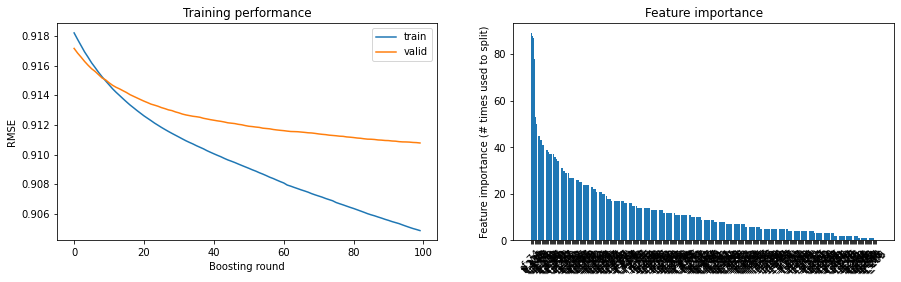

In [24]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results["train"]["rmse"], label="train")
axs[0].plot(evaluation_results["valid"]["rmse"], label="valid")
axs[0].set_ylabel("RMSE")
axs[0].set_xlabel("Boosting round")
axs[0].set_title("Training performance")
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({"features": booster.feature_name(), "importance": booster.feature_importance()}).sort_values(
    "importance", ascending=False
)
axs[1].bar(x=np.arange(len(importances)), height=importances["importance"])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances["features"], rotation=45)
axs[1].set_ylabel("Feature importance (# times used to split)")
axs[1].set_title("Feature importance")

plt.show()